In [1]:
import os
import time
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from nndrain.tensor_edit import TensorEdit
from nndrain.simplify_linear import SimplifyLinear
import nndrain.utils as utils

utils.set_seed(42)

In [2]:
# Fully connected neural network with SimplifyLinear modules
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc = nn.ModuleList()

        for i_l in range(len(hidden_size)+1):
            in_size = 0
            out_size = 0
            if i_l==0:
                in_size = input_size
                out_size = hidden_size[0]
                simplify_row = True
                simplify_col = False
                exclude_from_drain = True
            elif i_l == len(hidden_size):
                in_size = hidden_size[-1]
                out_size = output_size
                simplify_row = False
                simplify_col = True
                exclude_from_drain = False
            else:
                in_size = hidden_size[i_l-1]
                out_size = hidden_size[i_l]
                simplify_row = True
                simplify_col = True
                exclude_from_drain = False

            sl = SimplifyLinear(in_size, out_size, simplify_row, simplify_col, min_row=10, min_col=10, exclude_from_drain=exclude_from_drain)
            self.fc.append(sl)
        self.activation = nn.ReLU()

    def forward(self, x):
        out = x
        for i_l, l in enumerate(self.fc):
            out = self.fc[i_l](out)
            if i_l<len(self.fc)-1:
                out = self.activation(out)
        return out


In [3]:
# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define net parameters and model
input_size = 784
hidden_size = [20000, 500, 50]
num_classes = 10
model = Net(input_size, hidden_size, num_classes).to(device)
n_start_params = sum(p.numel() for p in model.parameters())

batch_size = 10
num_epochs = 150
epoch_values = []
train_accuracies = []
train_losses = []
test_accuracies = []
simplifications = []
inference_times = []

figsize=(12, 10)
outdir = 'out/mnist/fc'
isExist = os.path.exists(outdir)
if not isExist:
    os.makedirs(outdir)

In [4]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Loss and optimizer
lr = 1e-3
lossFun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

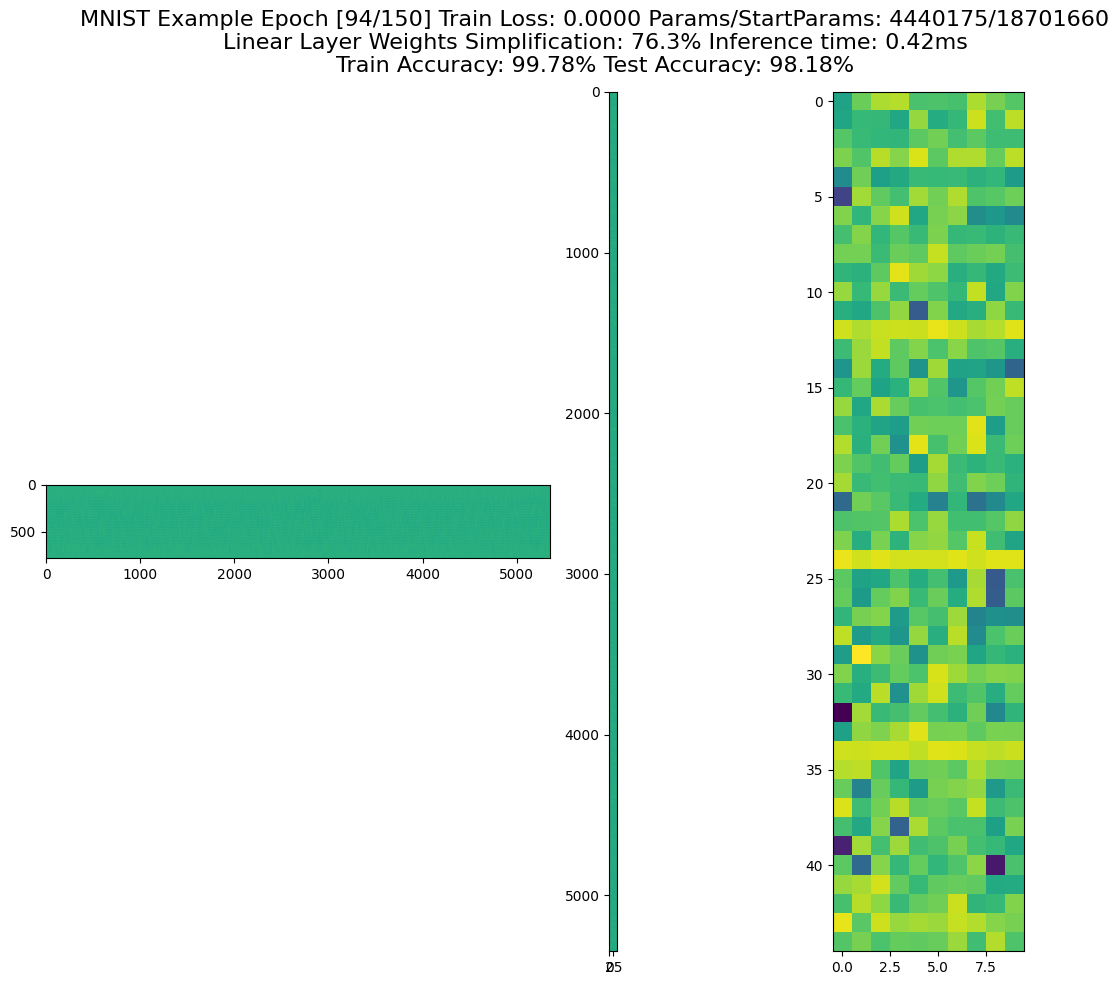

MNIST Example Epoch [94/150] Train Loss: 0.0000 Params/StartParams: 4440175/18701660 Linear Layer Weights Simplification: 76.3% Inference time: 0.42ms Train Accuracy: 99.78% Test Accuracy: 98.18%


In [5]:
%matplotlib inline

# weigth figure
fig_weight = plt.figure(figsize=figsize, facecolor='white')
filenames_weight = []
# select the layers that can be simplified
simplify_layers = [module for module in model.modules() if isinstance(module, SimplifyLinear)]
te = TensorEdit(simplify_layers)

# stop pruning condition
stop_simplification = False

for epoch in range(num_epochs):
    total_loss = 0
    samples = 0
    correct = 0

    model.train()
    for i, (images, labels) in enumerate(train_loader):  
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # only for MSE Loss
        #ones = torch.sparse.torch.eye(10).to(device)
        #labels_ones = ones.index_select(0, labels)
        loss = lossFun(outputs, labels)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        samples += labels.size(0)
        correct += (predicted == labels).sum().item()

        
        te.set_threshold()
        # apply weights decay
        te.weights_drain(p_drain=0.005, threshold_coeff=3.0, condition=stop_simplification==False and (epoch!=0 and epoch%5==0))
        te.weights_decay(p_decay=0.01, decay_rate=5e-3, condition=stop_simplification==False and (epoch!=0 and epoch%2==0))
        
    # remove weights if all values ​​in a row or column are less than the specified value
    if te.weights_remove(p_remove=1, threshold_coeff=0.5, max_removal=0.1, verbose=True, condition=stop_simplification==False):
        # re-instantiate the optimizer with the new model if I have deleted any rows or columns
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)


    # train loss, accuracy, number of parameters
    epoch_values.append(epoch + 1)
    train_accuracy = 100 * correct / samples
    train_loss = total_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    n_params = sum(p.numel() for p in model.parameters())
    simplification = (1 - n_params / n_start_params) * 100
    simplifications.append(simplification)

    # test the model
    model.eval()
    test_accuracy = 0
    test_dt = 0
    
    with torch.no_grad():
        correct = 0
        test_samples = 0
        tnow = time.time()
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_samples += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_dt = 1000 * (time.time() - tnow) / test_samples
        test_accuracy = 100 * correct / test_samples
        test_accuracies.append(test_accuracy)
        inference_times.append(test_dt)
    
    # select the weight matrices transposing them for a better visualization
    weights = [w.weight.data.T for w in simplify_layers]
    title1 = "MNIST Example Epoch [{}/{}] Train Loss: {:.4f} Params/StartParams: {}/{}"\
                .format(epoch+1, num_epochs, loss.item(), n_params, n_start_params)
    title2 = "Linear Layer Weights Simplification: {:.1f}% Inference time: {:.2f}ms"\
                .format(simplification, test_dt)
    title3 = "Train Accuracy: {:.2f}% Test Accuracy: {:.2f}%"\
                .format(train_accuracy, test_accuracy)
    utils.plot_weights(fig_weight, weights, '\n'.join((title1, title2, title3)))
    
    # create a file name, append it to the filenames list
    filename = '/'.join((outdir, f'frame_weight_{epoch+1}.png'))
    filenames_weight.append(filename)
    # and save the figure
    fig_weight.savefig(filename, facecolor=fig_weight.get_facecolor())
    plt.clf()

    print(' '.join((title1, title2, title3)))

    if simplification > 80.0 and test_accuracy > 98.0:
        stop_simplification = True

    

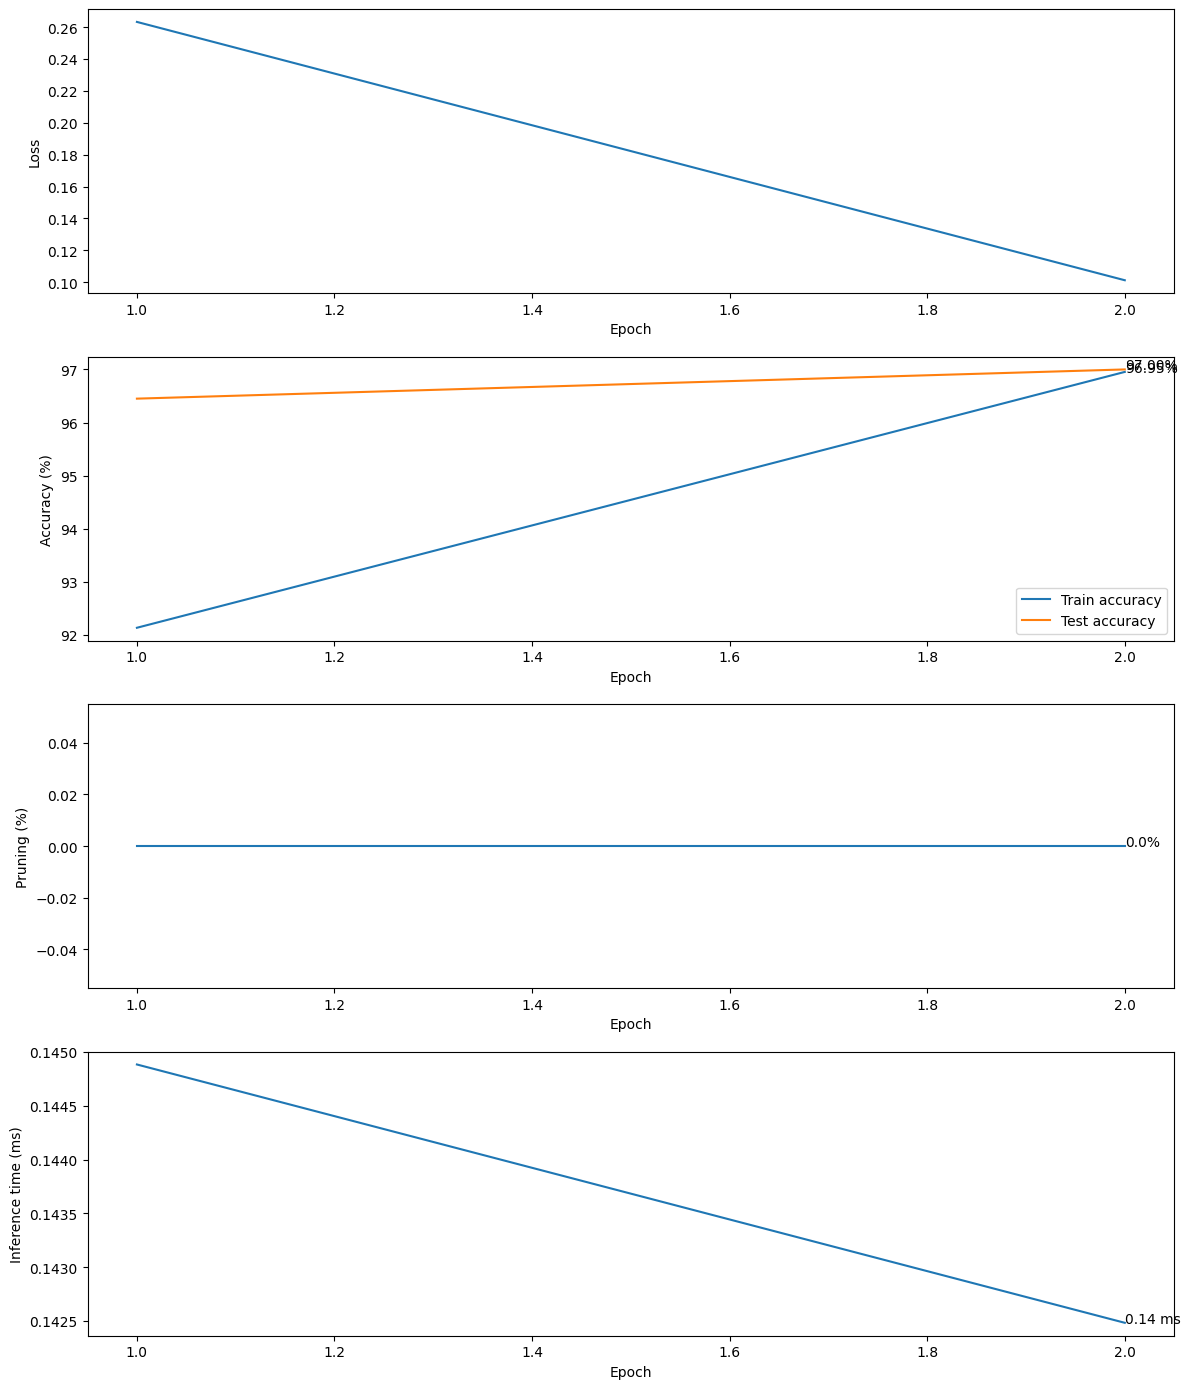

<Figure size 1200x1400 with 0 Axes>

In [ ]:
fig_chart = plt.figure(figsize=(12,14), facecolor='white')
filenames_chart = []


for epoch in range(num_epochs):
    f=epoch+1
    utils.plot_charts(fig_chart, epochs=epoch_values[:f], losses=train_losses[:f], train_accuracies=train_accuracies[:f], test_accuracies=test_accuracies[:f], simplifications=simplifications[:f], inference_times=inference_times[:f])

    # Create file name and save figure
    filename = '/'.join((outdir, f'frame_chart_{epoch+1}.png'))
    filenames_chart.append(filename)
    fig_chart.savefig(filename, facecolor=fig_chart.get_facecolor())

    time.sleep(0.05)
    plt.clf()

In [ ]:
filenames = []
# Merge vertically the two images for each frame
for idf, (fw_name, fc_name) in enumerate(zip(filenames_weight, filenames_chart)):
    # Merge the two images
    result = utils.merge_images(fw_name, fc_name)
    
    # Create file name and save figure
    filename = '/'.join((outdir, f'frame_{idf+1}.png'))
    filenames.append(filename)
    result.save(filename)

In [ ]:
# build a gif by composing the frames
utils.images_to_gif(filenames, '/'.join((outdir, 'mnist_fc.gif')), tail=100)

# create a mjpg video
utils.images_to_avi(filenames, '/'.join((outdir, 'mnist_fc.avi')))

# Remove frame files
for f in set(filenames_weight):
    os.remove(f)
for f in set(filenames_chart):
    os.remove(f)
for f in set(filenames):
    os.remove(f)

In [ ]:
# remove all the remaining png files
import glob

for f in glob.glob(outdir + '/*.png'):
    os.remove(f)